In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 10, 6
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)


In [2]:
dataset = pd.read_csv("AirPassengers.csv")

In [3]:
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
# Convert the Month column from string to datetime object.
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [6]:
dataset = dataset.sort_values('Month')
dataset['Month'].min(), dataset['Month'].max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [7]:
indexedDataset = dataset.set_index('Month')

In [8]:
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


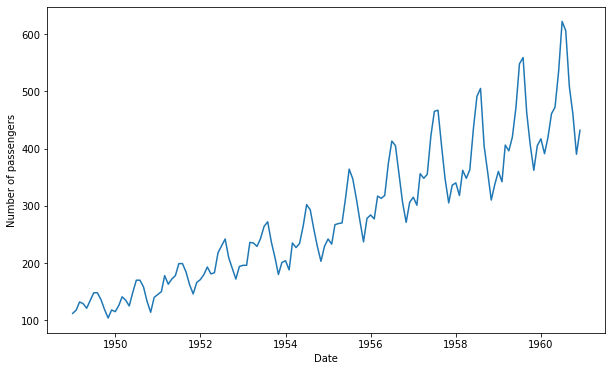

In [9]:
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.plot(indexedDataset)

In [10]:
# The above data is not stationary and shows an upward trend.

In [11]:
# Determining rolling statistics. Window = 12 denotes yearly interval (12 months)

rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()



In [12]:
rolmean

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


In [13]:
rolstd

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


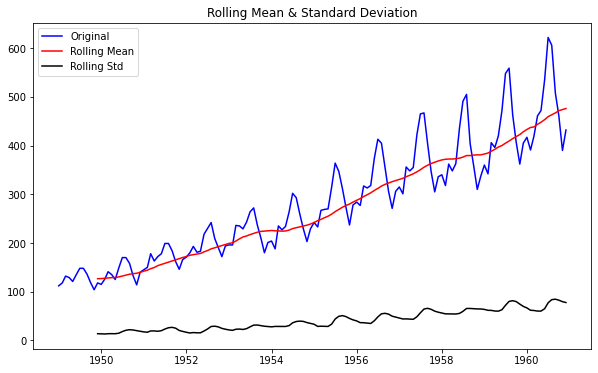

In [14]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title("Rolling Mean & Standard Deviation")
plt.show()

In [15]:
# Hence from the above plot it is quite evident that the mean and std of the time series is not stationary.

In [16]:
# Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of Observations used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
dftest

(0.8153688792060568,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

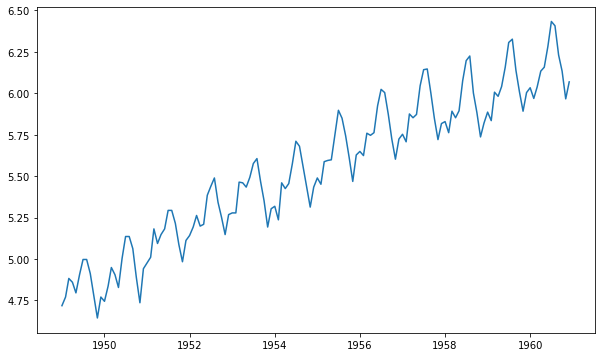

In [18]:
# Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

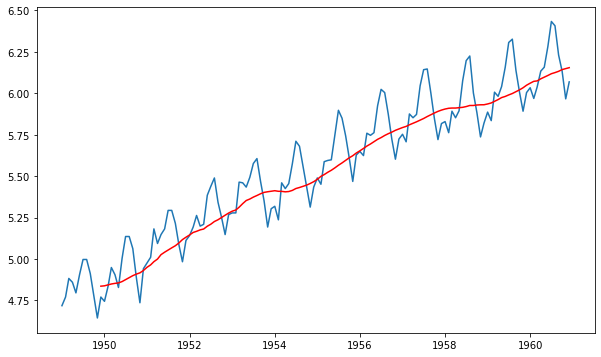

In [19]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red') 

In [20]:
# Making the time series stationary
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [21]:
# Wrapping the above in a function
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller test: ")
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

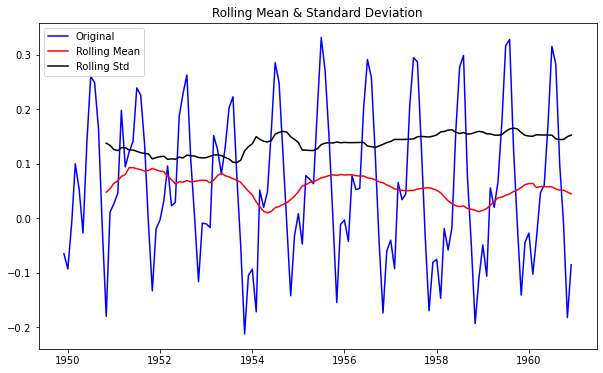

Results of Dickey-Fuller test: 
Test Statistic                  -3.162908
p-value                          0.022235
#Lags used                      13.000000
Number of Observations used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [22]:
test_stationarity(datasetLogScaleMinusMovingAverage)
# Low p-value indicates that time series is stationary, since we can reject the null hypothesis

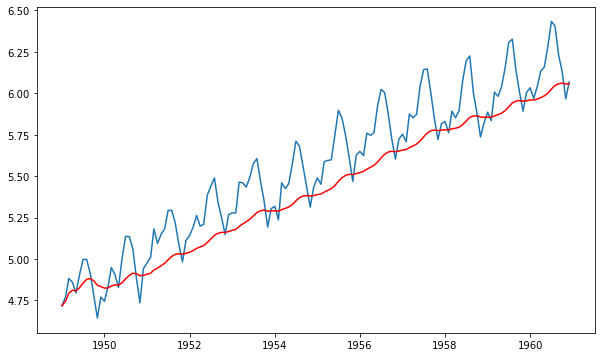

In [23]:
# The below is done to see the trend in our time-series
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

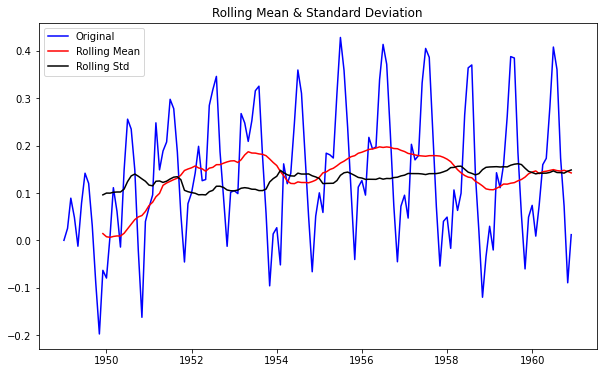

Results of Dickey-Fuller test: 
Test Statistic                  -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of Observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
# removing weighted mean from the time-series
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

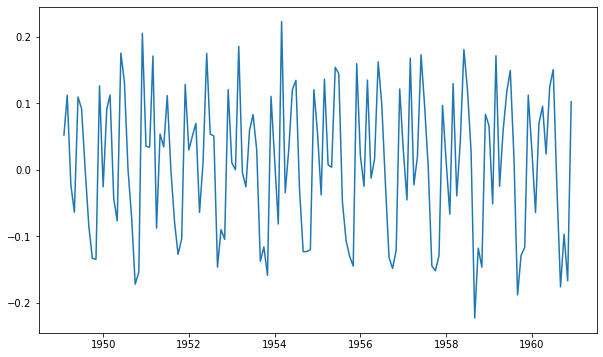

In [25]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

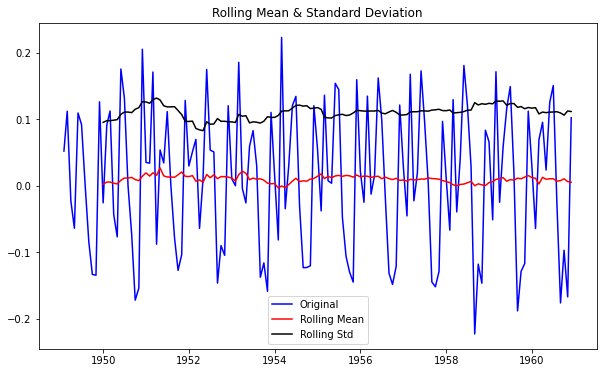

Results of Dickey-Fuller test: 
Test Statistic                  -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of Observations used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [26]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

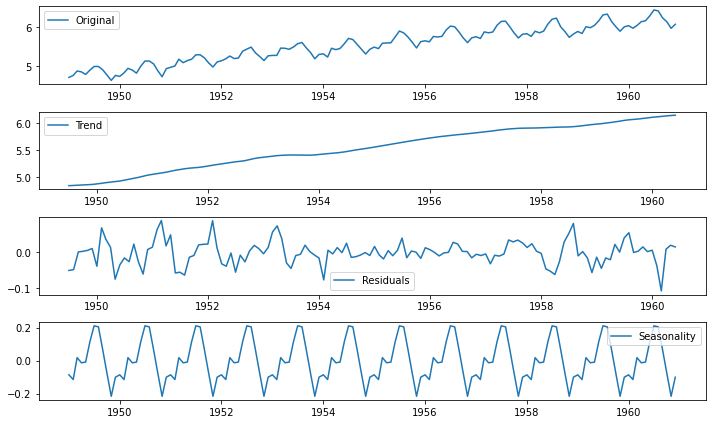

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()



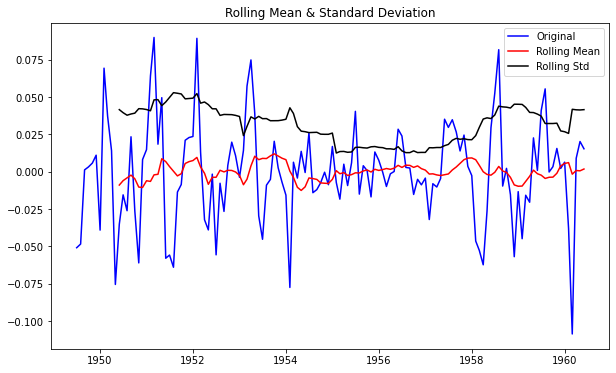

Results of Dickey-Fuller test: 
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags used                     9.000000e+00
Number of Observations used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [28]:
decomposedLogData = pd.DataFrame(residual)    
decomposedLogData.dropna(inplace=True)
decomposedLogData = decomposedLogData.rename(columns={'resid': '#Passengers'})
test_stationarity(decomposedLogData)

C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function')

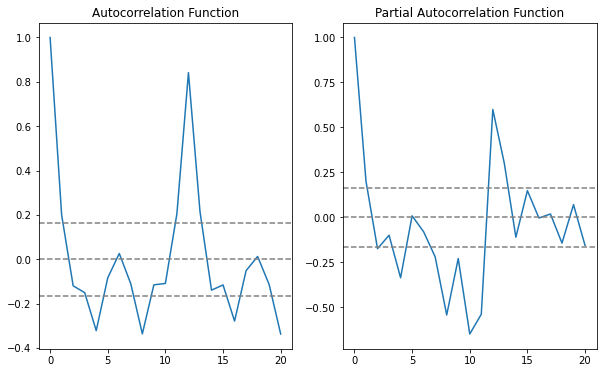

In [29]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols') #Ordinary Least Squares Methdod

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')


#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

In [30]:
# In PACF graph, since the first time it cuts 0.00 at approx 2 hence p=2
#Similiarly, in the ACF graph since it cuts 0.0 at approx 2 hence q=2

C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was p

Plotting ARiMA Model


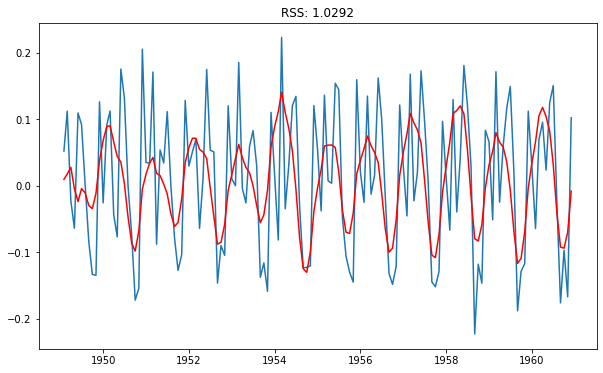

In [31]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(indexedDataset_logScale, order=(2,1,2)) #order=(p,d,q)
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARiMA Model')

#Lesser the RSS, better the model

C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR Model


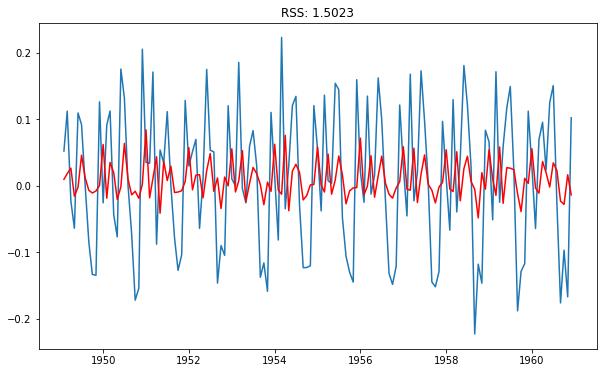

In [32]:
#AR model
model = ARIMA(indexedDataset_logScale, order=(2,1,0)) #order=(p,d,q), for AR model q=0
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR Model')


C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sahil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting MA Model


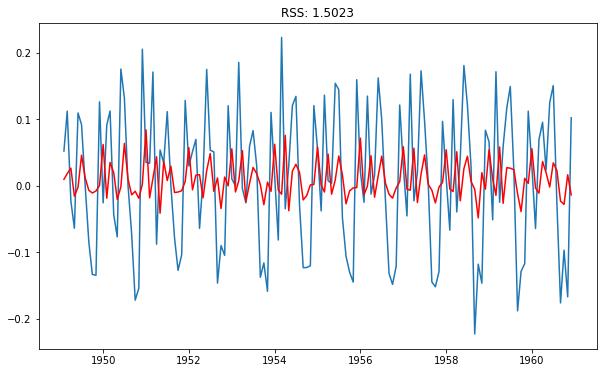

In [33]:
#MA model
model = ARIMA(indexedDataset_logScale, order=(0,1,2)) #order=(p,d,q), for MA model p=0
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA Model')

In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [35]:
# Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [38]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predicitons_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predicitons_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

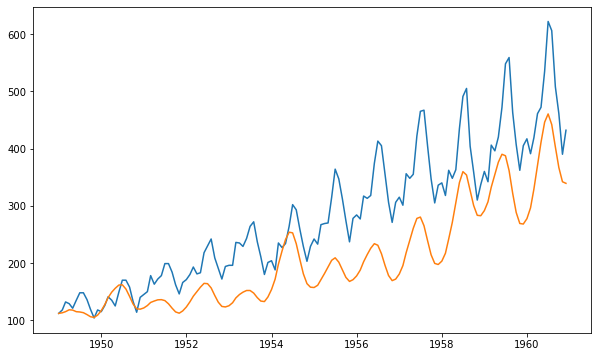

In [39]:
predictions_ARIMA = np.exp(predicitons_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)


In [40]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


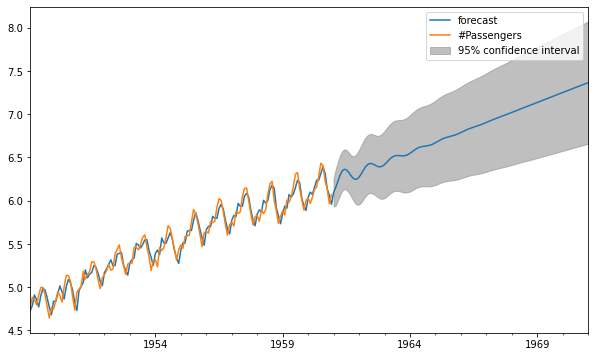

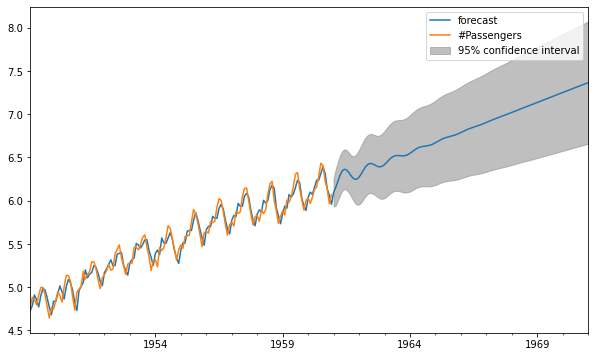

In [43]:
results_ARIMA.plot_predict(1,264) # I want to predict for next ten years hence 144+120 = 264, since dataset contains data of 144 rows and for the next ten years it will be (10*12)=120

In [46]:
x=results_ARIMA.forecast(steps=120)
x

(array([6.09553401, 6.15281417, 6.22442981, 6.29241113, 6.34164722,
        6.36359361, 6.35784681, 6.33139299, 6.2959754 , 6.26447721,
        6.24738341, 6.25025193, 6.27275861, 6.30940335, 6.35151512,
        6.38988667, 6.41727386, 6.43011055, 6.4290669 , 6.41842494,
        6.40456166, 6.39403635, 6.39183108, 6.40019533, 6.41833723,
        6.44295435, 6.46937458, 6.49294003, 6.51024132, 6.51989045,
        6.52267591, 6.52112404, 6.51864549, 6.51853718, 6.52311955,
        6.53322396, 6.54812905, 6.5659159 , 6.58410338, 6.60036565,
        6.61313289, 6.62192803, 6.62737812, 6.63093156, 6.63438721,
        6.63938021, 6.64696544, 6.65739882, 6.67015365, 6.6841429 ,
        6.69806663, 6.71077935, 6.72157765, 6.73034017, 6.73749845,
        6.74386416, 6.75037363, 6.75782636, 6.76668728, 6.7769987 ,
        6.78841366, 6.80032899, 6.81207239, 6.82308803, 6.83307179,
        6.84202536, 6.85022357, 6.85811268, 6.86617389, 6.87479202,
        6.88416355, 6.89426437, 6.90487943, 6.91